## Example of Trans-C sampling across independent model states

This notebook demonstrates sampling across unormalized multi-dimensional Gaussian PDFs in states with non-consequtive dimensions
using the State-Jump sampler.

In [1]:
# general python utility packages
import time
from collections import Counter
from functools import partial

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize

#### TransC class

In [ ]:
%%writefile gaussians_functions.py
"""
Gaussian example functions for Trans-C sampling.

These functions are defined in a separate module to ensure compatibility
with multiprocessing on macOS and Windows, which use 'spawn' instead of 'fork'.
"""

import numpy as np
import scipy.stats as stats


def flatten_extend(matrix):
    """Flatten a 2D matrix into a 1D numpy array."""
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)


def _log_posterior(x, state, ndims, mu, cov, weights, icov=False):
    """Multi-state log Posterior PDF evaluation (unormalised) for three multi-dimensional Gaussians."""
    w = weights[state]
    mean = mu[state]
    covar = cov[state]
    r = mean - x
    if icov:
        if ndims[state] == 1:
            log_const = (
                np.log(w) - 0.5 * len(x) * np.log(2 * np.pi) - 0.5 * np.log(covar[0])
            )
            out = log_const - 0.5 * np.dot(r, r) * (covar[0])
        else:
            log_const = (
                np.log(w)
                - 0.5 * len(x) * np.log(2 * np.pi)
                - 0.5 * np.log(np.linalg.det(covar))
            )
            out = log_const - 0.5 * np.dot(r, np.dot(covar, r))
    else:
        if ndims[state] == 1:
            log_const = (
                np.log(w) - 0.5 * len(x) * np.log(2 * np.pi) - 0.5 * np.log(covar[0])
            )
            out = log_const - 0.5 * np.dot(r, r) / (covar[0])
        else:
            log_const = (
                np.log(w)
                - 0.5 * len(x) * np.log(2 * np.pi)
                - 0.5 * np.log(np.linalg.det(covar))
            )
            out = log_const - 0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out


class IsotropicGaussianProposal:
    """Class for isotropic Gaussian proposal for state jump sampler."""

    def __init__(self, ndims, rng):
        self.std = [
            [0.04] * nd for nd in ndims
        ]  # Proposal variance for each parameter in state
        self.rng = rng

    def __call__(self, x: np.ndarray, state: int) -> float:
        """Call method to generate proposal."""
        return 0.0  # log ratio for symmetric proposal

    def propose(self, x: np.ndarray, state: int) -> np.ndarray:
        """Propose from the proposal distribution."""
        i = self.rng.choice(np.arange(len(x)))
        var = self.std[state][i] ** 2
        _x = np.copy(x)
        _x[i] += stats.multivariate_normal.rvs(mean=0.0, cov=var, random_state=self.rng)
        if not isinstance(_x, np.ndarray):
            _x = np.array([_x])  # deal with 1D case which returns a scalar
        return _x

In [ ]:
# Import the functions and class we just wrote to the module
from gaussians_functions import flatten_extend, _log_posterior, IsotropicGaussianProposal

### Cross-platform multiprocessing compatibility

**Note on macOS/Windows compatibility:** The functions below are defined in a separate module to ensure compatibility with multiprocessing on macOS and Windows.

- **Why?** macOS and Windows use `spawn` for multiprocessing (not `fork` like Linux)
- **What does this mean?** Functions must be picklable (defined at module level, not inline in notebooks)
- **Solution:** We use `%%writefile` to create a module file while keeping the code visible in the notebook

This ensures the notebook works on Linux, macOS, and Windows without modification.

In [2]:
from pytransc.analysis.laplace import run_laplace_evidence_approximation
from pytransc.analysis.samples import get_transc_samples
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_state_jump_sampler, run_mcmc_per_state
from pytransc.utils.auto_pseudo import PseudoPriorBuilders, build_auto_pseudo_prior

--------

## Example set up: Three states with non-consecutive dimensions, 3D, 5D and 10D Gaussians

Set some global control parameters for all examples.

In [4]:
plotting = True  # Create some diagnostic displays of outputs
parallel = False  # Use parallel computation for sampling
autopseudo = True  # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False  # Thin internally generated within state posterior ensembles by their auto-correlation
# (This can take additional compute time, and is not necessary if input ensembles are already independent.)

Define log posterior PDF for three states with Gaussian posterior PDF.

First we set up three unormalized Gaussian states.

In [5]:
# Set up PDFs in each state
nstates = 3  # Number of states
ndims = [3, 5, 10]  # Number of dimensions for each state
weights = [
    0.56,
    0.3,
    0.14,
]  # weights for each state (become true values for relative evidence/marginal Likelihoods.
trueML = weights / np.sum(
    weights
)  # true values of marginal Likelihoods/relative evidences
mu = [
    [0.8, 0.8, 0.8],
    [0.3 for i in range(5)],
    [0.5 for i in range(10)],
]  # Gaussian means for each state
sig = [0.02, 0.05, 0.08]  # standard deviations of Gaussians in each state
cov = [
    np.diag(np.ones(ndims[i]) * sig[i] ** 2) for i in range(nstates)
]  # covariance matrices for each state
if True:  # rotate the covariance matrices
    np.random.seed(210165)  # noqa: NPY002
    new_cov = []
    for i in range(nstates):
        rotation_matrix = np.random.rand(ndims[i], ndims[i]) - 0.5  # noqa: NPY002
        new_cov.append(rotation_matrix @ cov[i] @ rotation_matrix.T)
    cov = new_cov
icov = [
    1.0 / cov[0],
    np.linalg.inv(cov[1]),
    np.linalg.inv(cov[2]),
]  # inverse covariance matrices for each state

### Log-posteripr PDF
Define log_posterior function using these Gaussian PDFs.

In [ ]:
# Create partial function binding parameters
log_posterior = partial(_log_posterior, ndims=ndims, mu=mu, cov=cov, weights=weights)

### Starting points for MCMC samplers

In [7]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nll = lambda *args: -log_posterior(*args)
initial = np.array([0.5])
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print(f"x_ml = {soln.x[0]:.3f}")

Maximum likelihood estimates:
x_ml = 0.800
x_ml = 0.300
x_ml = 0.500


### Decide on normalized pseudo prior PDFs

Here we demonstrate how to define a pseudo_prior PDF by fitting a mixture model approximation to existing ensembles.

Our implementation of an automatic pseudo prior function, uses the supplied class function `build_auto_pseudo_prior`.
`build_auto_pseudo_prior()` will conduct some quick initial sampling in each state, and fit a Gaussian Mixture to these samples.


In truth the question of how to build a normalized PDF approximation of the posterior (for use as a pseudo-prior) is an open question, and so `build_pseudo_prior` should be taken as a simple example implementation of this.

In [ ]:
# Generate posterior ensembles in each state for pseudo-prior fitting
ensemble_per_state, _ = run_mcmc_per_state(
    n_states=nstates,
    n_dims=ndims,
    n_walkers=nwalkers_auto,
    n_steps=nsteps_auto,
    pos=pos,
    log_posterior=log_posterior,
    auto_thin=True,
    verbose=False,
)

# Build pseudo-prior from the posterior ensembles
log_pseudo_prior = build_auto_pseudo_prior(
    ensemble_per_state=ensemble_per_state,
    reg_covar=0.0,
)


-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C samping across model states with the State-Jump sampler 

Here we demonstrate use of the Pseudo-prior sampler.

This formulation is equivalent to the *Product-space sampler* with the proposal for the other state variables equal to the pseudo prior, for which moves are then accepted with probability one. As a consequence the only pair of model states that need be considered are the 
 and 
 states (i.e. same as in Reversible-Jump).

- For within-state moves the acceptance is the usual M-H condition with proposal = to users choice for that state, defined by routine log_proposal. This can be any perturbative proposal PDF designed by the user, or an automatic one found by fitting a Gaussian mixture model to some trial samples. (The class function `build_pseudo_prior` can be used to do this.)

- For between-state moves we assume that only the state index changes, 
 , and hence the model in state 
 must be a draw from the pseduo prior for that state. The acceptance term then only involves the likelihood ratio and the pseudo prior ratio for the two states.

In [ ]:
# define model proposal for within state moves
# Create instance of IsotropicGaussianProposal with necessary parameters
log_proposal = IsotropicGaussianProposal(ndims=ndims, rng=rng)

In [10]:
# pseudo prior proposal algorithm set up
nwalkers_pp = 32  # Number of walkers for product space
nsteps_pp = 100000  # Number of chain steps for product space
pos_states = rng.choice(
    np.arange(nstates), nwalkers_pp
)  # Initial states of each walker
pos = []
for i in range(nwalkers_pp):  # generate starting points for each walker
    pos.append(
        ml[pos_states[i]] + 1e-4 * rng.standard_normal(ndims[pos_states[i]])
    )  # add random perturbation to maximum Likelihood models

In [11]:
start_time = time.time()
state_jump_chains = run_state_jump_sampler(
    nwalkers_pp,
    nsteps_pp,
    nstates,
    ndims,
    pos,
    pos_states,
    log_posterior,
    log_pseudo_prior,
    log_proposal,    progress=True,
)
elapsed_time = time.time() - start_time

alg = "TransC-state-jump-sampler"
state_chain_tot = np.swapaxes(state_jump_chains.state_chain_tot, 0, 1)
state_chain = state_jump_chains.state_chain.T
model_chain = state_jump_chains.model_chain
accept_within_per_walker = (
    state_jump_chains.accept_within / state_jump_chains.prop_within
)
accept_between_per_walker = (
    state_jump_chains.accept_between / state_jump_chains.prop_between
)
accept_within = 100 * np.mean(accept_within_per_walker)
accept_between = 100 * np.mean(accept_between_per_walker)

2025-08-06 12:17:17 [INFO] pytransc.samplers.state_jump: Running state-jump trans-C sampler
2025-08-06 12:17:17 [INFO] pytransc.samplers.state_jump: Number of walkers: 32
2025-08-06 12:17:17 [INFO] pytransc.samplers.state_jump: Number of states being sampled: 3
2025-08-06 12:17:17 [INFO] pytransc.samplers.state_jump: Dimensions of each state: [3, 5, 10]
100%|██████████| 32/32 [05:35<00:00, 10.50s/it]


In [12]:
# print some diagnostics
print("\n Algorithm type                                   :", alg)
# extract trans-D samples and chains
discard = 0  # chain burnin
thin = 15  # chain thinning
thin = 1  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=state_jump_chains,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    state_jump_chains.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    state_jump_chains.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    state_jump_chains, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    state_jump_chains.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    state_jump_chains.state_chain_tot[:, -1, :]
)

print(" Total number of state changes for all walkers    :", total_state_changes)
print(
    " Number of state changes for each walker          :\n",
    *state_changes_per_walker,
)
print(
    " Acceptance rates for walkers within states:  \n",
    accept_within_per_walker,
    "\n",
)
print(
    " Acceptance rates for walkers between states: \n",
    accept_between_per_walker,
    "\n",
)
print(
    " Average % acceptance rate for within states      :",
    np.round(accept_within, 2),
)
print(
    " Average % acceptance rate for between states     :",
    np.round(accept_between, 2),
)
print(
    " Auto correlation time for between state sampling :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" True relative marginal Likelihoods               :", trueML)
print(
    " Estimated relative evidences                     :",
    relative_marginal_likelihoods,
)
print(
    " Elapsed time.                                    :",
    np.round(elapsed_time, 2),
    "s \n",
)


 Algorithm type                                   : TransC-state-jump-sampler
 Total number of state changes for all walkers    : 172827
 Number of state changes for each walker          :
 5276 5442 5335 5332 5403 5493 5403 5425 5296 5289 5502 5521 5402 5436 5545 5408 5422 5308 5472 5386 5373 5270 5364 5481 5432 5425 5392 5458 5412 5464 5360 5300
 Acceptance rates for walkers within states:  
 [0.15068782 0.14994885 0.14992279 0.14825433 0.15029043 0.15118312
 0.14909463 0.15052974 0.14836202 0.14910063 0.14842777 0.15241822
 0.14902004 0.15189184 0.15245326 0.14891962 0.15381713 0.14690933
 0.14994438 0.14947801 0.14981648 0.14900203 0.15381367 0.15040257
 0.14872074 0.1512392  0.14934466 0.15195583 0.14900857 0.15102876
 0.14873435 0.14987903] 

 Acceptance rates for walkers between states: 
 [0.53115876 0.54009528 0.53419445 0.53298021 0.54241542 0.53879353
 0.53830826 0.53974729 0.53226131 0.53826583 0.54670111 0.55006476
 0.54318753 0.54030414 0.55240088 0.53907496 0.54878543 0.

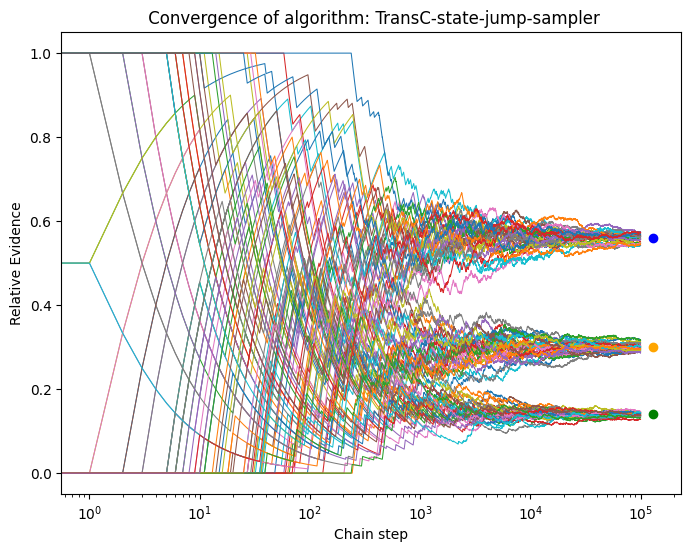

In [13]:
# plot relative number of visit to each state along the chain
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))
    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, trueML[0], "bo")
    plt.plot(len(visits) * 1.3, trueML[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, trueML[2], "go")
    plt.title(" Convergence of algorithm: " + alg)
    # plt.savefig('convergence_state_3-5-10.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains of the Product-space sampler are 
converging, and visiting each state in proportion to the correct normalization constant. 

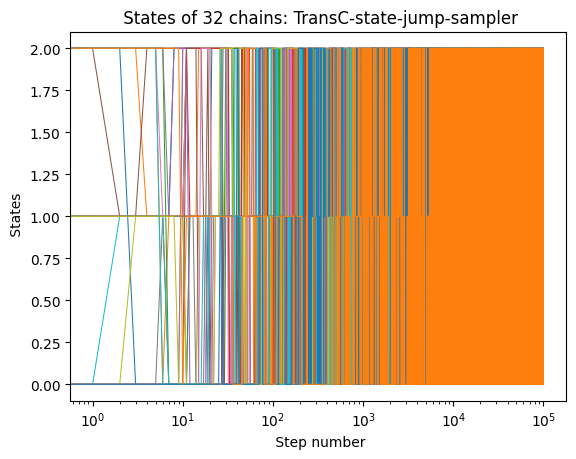

In [14]:
# plot chain states
if plotting:
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0], -1), lw=0.75)
    plt.xlabel(" Step number")
    plt.ylabel(" States")
    title = " States of " + str(nwalkers_pp) + " chains: " + alg
    plt.title(title)
    # plt.savefig('convergence.pdf')
    plt.show()

This plot shows the movement of each chain between states.

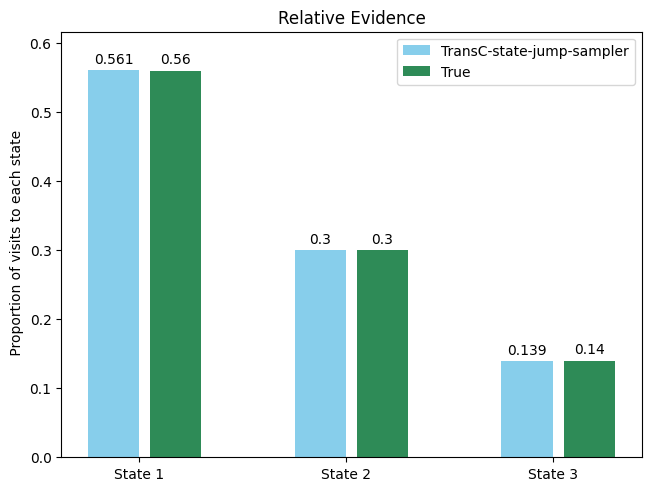

In [15]:
# Count visits to each state by Trans-D mcmc
if plotting:
    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)

    # plot histogram of frequency of visits to each state

    labels = ("State 1", "State 2", "State 3")
    labels = ["State " + str(i + 1) for i in np.arange(nstates)]

    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")

    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    # rects = ax.bar(x + offset, np.round(h,3), width, label='Trans-D',color='lightcoral')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(trueML, 3), width, label="True", color="seagreen"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    ax.set_ylim(0.0, np.max(np.maximum(h, trueML)) * 1.1)
    # plt.savefig('Marginal_Likelihoods.png')
    plt.show()

 State;  0  in  3  dimensions
 State;  1  in  5  dimensions
 State;  2  in  10  dimensions


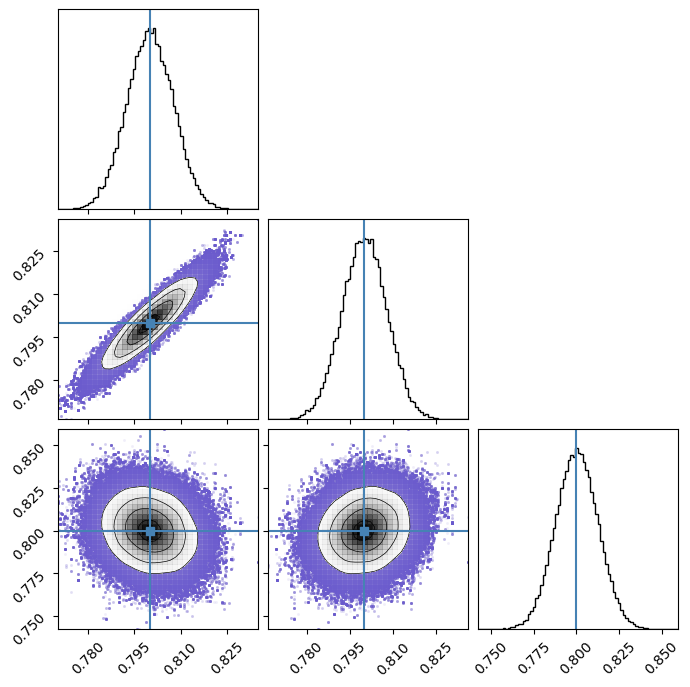

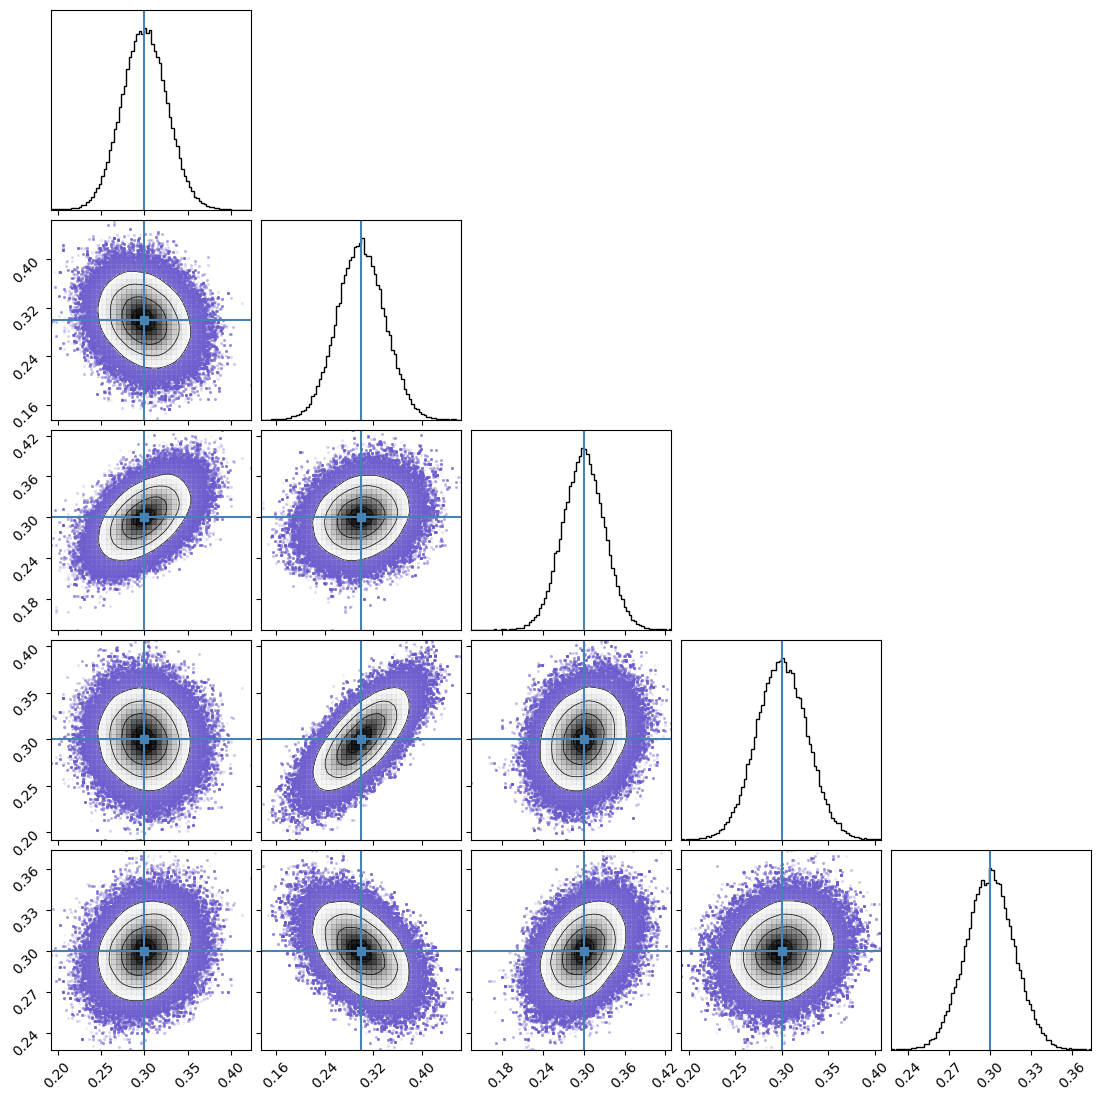

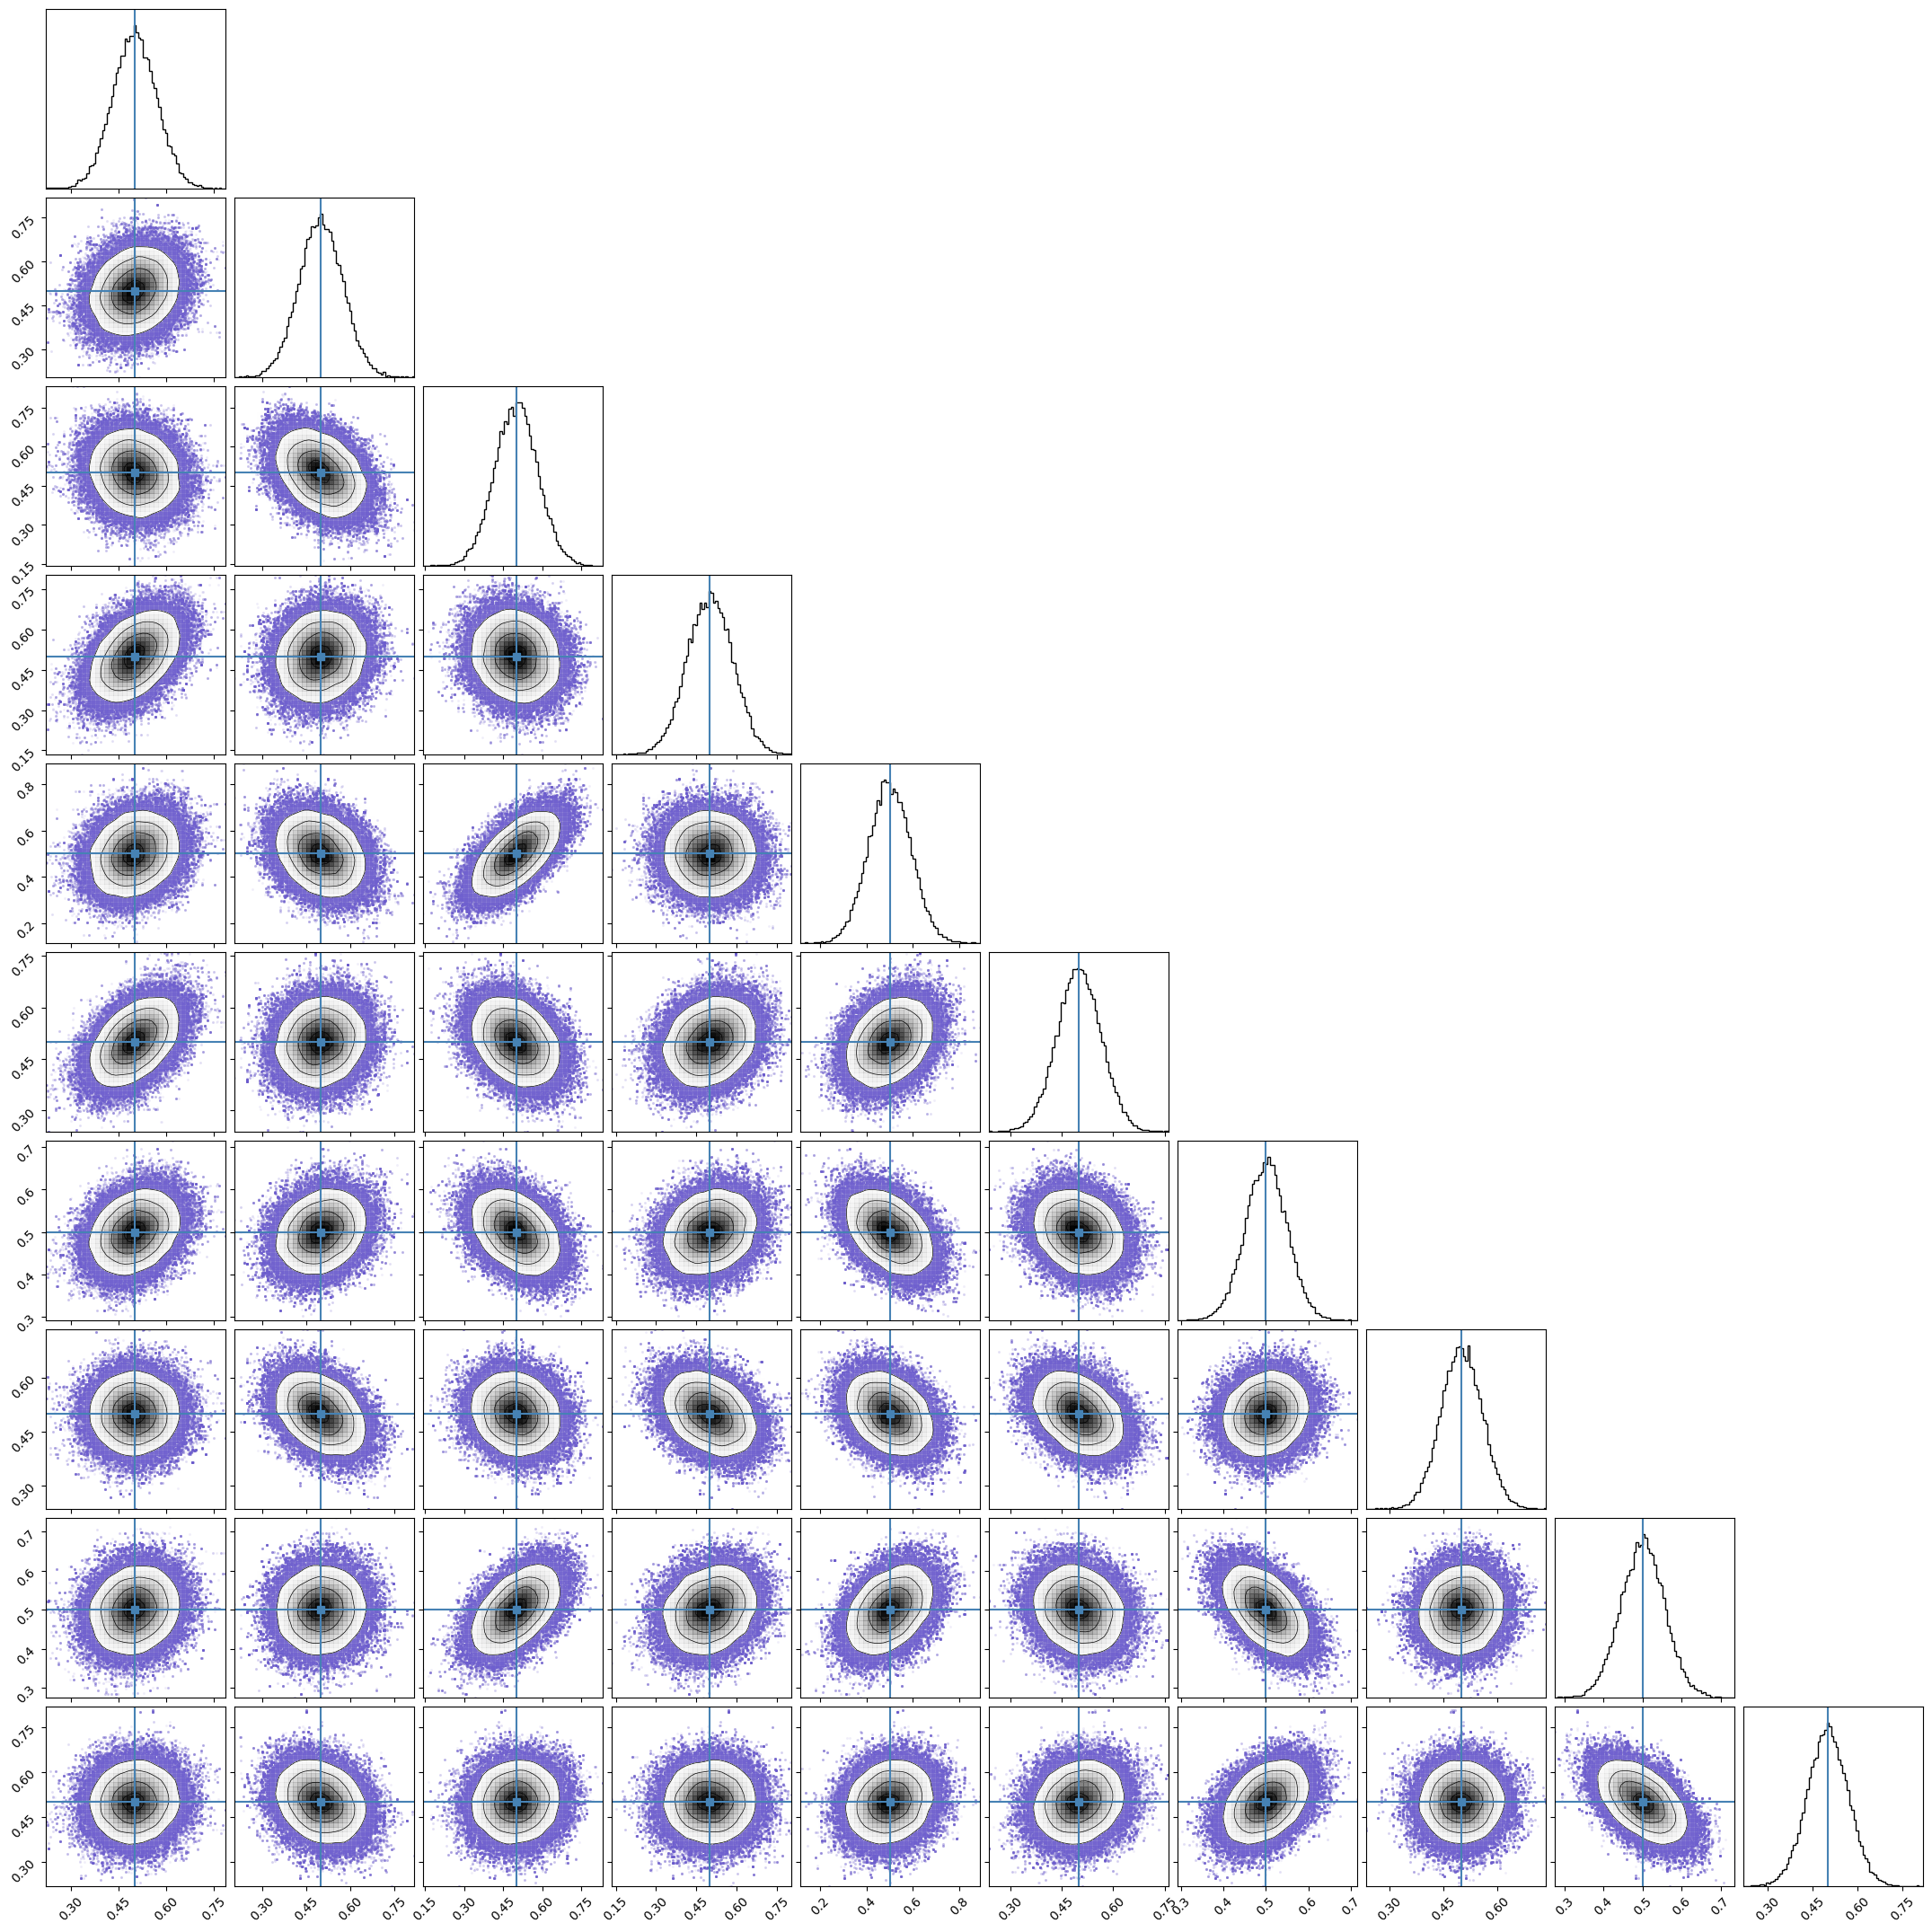

In [16]:
# corner plots to check sampling within each state

if plotting:
    # collect trans samples
    transc_ensemble = get_transc_samples(
        state_jump_chains,
        discard=0,
        thin=thin,
    )
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "slateblue"}
    for i in range(nstates):
        string = "State " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            flatten_extend(transc_ensemble[i]).reshape(-1, ndims[i]),
            truths=mu[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )

Sampling within each state looks reasonable. 

In [17]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

 Here is the Trans-C ensemble with
 1794068 samples in state 1
 960150 samples in state 2
 445782 samples in state 3
 
 [array([[0.79988695, 0.79833663, 0.78700722],
       [0.79988695, 0.79833663, 0.78700722],
       [0.79988695, 0.79833663, 0.78700722],
       ...,
       [0.80301186, 0.80283425, 0.78575574],
       [0.80301186, 0.80283425, 0.78575574],
       [0.80301186, 0.80283425, 0.78575574]], shape=(1794068, 3)), array([[0.29059542, 0.31500342, 0.26573549, 0.3111034 , 0.28424168],
       [0.29059542, 0.32340182, 0.26573549, 0.3111034 , 0.28424168],
       [0.28364587, 0.3572756 , 0.33353266, 0.32959611, 0.29544176],
       ...,
       [0.32036401, 0.21608531, 0.267379  , 0.24018954, 0.29395523],
       [0.32036401, 0.21608531, 0.267379  , 0.24018954, 0.29395523],
       [0.32036401, 0.21608531, 0.267379  , 0.24018954, 0.29395523]],
      shape=(960150, 5)), array([[0.5169582 , 0.50004481, 0.49983144, ..., 0.50004463, 0.49991934,
        0.49987174],
       [0.5169582 , 0.500044

---------

### Example of using Laplace approximation

Here is an example of using the Laplace approximation to calculate evidence for each state using log-posterior function and guessed MAP models.

In [18]:
MAP_guess = [
    np.array([0.0 for i in range(3)]),
    np.array([0.0 for i in range(5)]),
    np.array([0.0 for i in range(10)]),
]  # starting points for MAP optimization in each state (even though we actually know the MAP models!)

In [19]:
(
    laplace_hessians,
    laplace_map_models,
    laplace_map_log_posteriors,
    laplace_log_marginal_likelihoods,
) = run_laplace_evidence_approximation(
    nstates,
    ndims,
    log_posterior,
    MAP_guess,
    optimize=True,
)
tot = np.sum(np.exp(laplace_log_marginal_likelihoods))
print(
    " Estimated relative evidences                        :",
    *np.round((np.exp(laplace_log_marginal_likelihoods)) / tot, 8),
)
print(" MAP models per state from optimization              ")
for i in range(3):
    print(" State              ", i, ":", laplace_map_models[i])

 Estimated relative evidences                        : 0.56 0.3 0.14
 MAP models per state from optimization              
 State               0 : [0.79999951 0.79999949 0.79999997]
 State               1 : [0.29999991 0.29999987 0.30000007 0.29999971 0.29999994]
 State               2 : [0.49999919 0.49999981 0.49999897 0.49999913 0.49999914 0.50000036
 0.50000029 0.4999995  0.49999841 0.50000065]
